In [0]:
!pip3 install torch===1.2.0 torchvision===0.4.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip3 install numpy

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 748.9MB 19kB/s 
     |████████████████████████████████| 8.8MB 24.4MB/s 
  Found existing installation: torch 1.1.0
    Uninstalling torch-1.1.0:
      Successfully uninstalled torch-1.1.0
  Found existing installation: torchvision 0.3.0
    Uninstalling torchvision-0.3.0:
      Successfully uninstalled torchvision-0.3.0


In [0]:
print("Importing Library...")
import torch
import torchvision
import torch.utils.data as putils
import matplotlib.pyplot as plt

from torch import nn, optim
from torchvision import datasets,transforms
from torch.autograd import Variable
from PIL import Image
from google.colab import drive

import numpy
import numpy as np
import math


print("Importing Library Success")

Importing Library...
Importing Library Success


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
print("Defining Class...")
class ComCNN(nn.Module):
    def __init__(self, channel):
        super(ComCNN, self).__init__()
        self.conv1 = nn.Conv2d(channel, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(64, affine=False)
        self.conv3 = nn.Conv2d(64, channel, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.relu(self.conv1(x))
        out = self.relu(self.bn1(self.conv2(out)))
        return self.conv3(out)

class MinMaxCNN(nn.Module):
    def __init__(self, channel,interpolate_size=2,mode='bicubic',deep=3):
        super(MinMaxCNN, self).__init__()
        self.deconv1 = nn.Conv2d(channel, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64, affine=False)
        self.deconv_n = nn.Conv2d(in_channels=64, out_channels=64,kernel_size=3, padding=1)
        self.bn_n = nn.BatchNorm2d(64, affine=False)
        self.deconv3 = nn.ConvTranspose2d(64, 2, kernel_size=3, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=3,stride=1,padding=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.interpolate_size = interpolate_size
        self.mode = mode

    def forward(self, x):
        # out = self.interpolate(x)
        out = x
        out = self.relu(self.deconv1(x))
        out = self.relu(self.bn_n(self.deconv_n(out)))
        out = (self.deconv3(out))
        out = self.maxpool(out)
        return self.sigmoid(out)
    
    def interpolate(self,x):
        return nn.functional.interpolate(input=x, scale_factor=self.interpolate_size, mode=self.mode,
                                         align_corners=False)

class BitmapRecCNN(nn.Module):
    def __init__(self, channel,interpolate_size=2,mode='bicubic',deep=3):
        super(BitmapRecCNN, self).__init__()
        self.deconv1 = nn.Conv2d(channel, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64, affine=False)
        self.deconv_n = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn_n = nn.BatchNorm2d(64, affine=False)
        self.deconv3 = nn.ConvTranspose2d(64, channel, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        self.interpolate_size = interpolate_size
        self.mode = mode
        self.deep = 5

    def forward(self, x):
        x = self.interpolate(x)
        out = self.relu(self.deconv1(x))
        for _ in range(self.deep):
            out = self.relu(self.bn_n(self.deconv_n(out)))
        out = self.sigmoid(self.deconv3(out))
        rounding = self.rounding_layer(out)
        return rounding

    def interpolate(self,x):
        return nn.functional.interpolate(input=x, scale_factor=self.interpolate_size, mode=self.mode,
                                         align_corners=False)

    def rounding_layer(self,batch_image):
        return batch_image.round()
    
    
class Network(nn.Module):
    def __init__(self,comCNN,bitmapCNN,minmaxCNN):
        super(Network,self).__init__()
        self.first = comCNN
        self.second = bitmapCNN
        self.third = minmaxCNN
        
    def forward(self, x):
        compact_repre = self.first(x.cuda())
        # print("repre : {}".format(compact_repre.shape))
        bitmap_repre = self.second(compact_repre.cuda())
        # print("bitmap : {}".format(bitmap_repre.shape))
        minmax_repre = self.third(compact_repre.cuda())
        # print("minmax : {}".format(minmax_repre.shape))
        recon = self.btc(bitmap_repre,minmax_repre)
        # print(recon.shape)
        
        
        return recon,minmax_repre,bitmap_repre,compact_repre
    
    def btc(self,bitmap,minmax):
        result = bitmap.clone()
        for i in range(len(minmax)):
            x = int(len(bitmap[i][0])/len(minmax[0][0]))
            y = int(len(bitmap[i][0])/len(minmax[0][0]))
            temp_output = bitmap[i][0].clone()
            block_image = torch.split(torch.cat(torch.split(bitmap[i][0], y, dim=1)), x)
            # min = numpy.split(numpy.concatenate(numpy.split(minmax[i][0],4,axis=1)),4)
            # max = numpy.split(numpy.concatenate(numpy.split(minmax[i][1],4,axis=1)),4)
            min = minmax[i][0].transpose(0,1).flatten()
            max = minmax[i][1].transpose(0,1).flatten()
            
            # print(block_image[0])
            # block_image[0][block_image[0] == 1] = 99
            # print(block_image[0])
            # 
            # print(len(min))
            # print(len(max))
            # print(len(block_image))
            
            for j in range(len(min)):
                block_image[j][block_image[j] == 1] = max[j]
                block_image[j][block_image[j] == 0] = min[j]
            
            # print(len(min))
            # print(len(max))
            # print(min)
            # print(max)
            
            block_image = torch.cat(block_image)
            temp_split = torch.split(block_image,int(len(bitmap[i][0])))
            temp_cat = torch.cat(temp_split,dim=1)
            
            result[i][0]  = temp_cat
            
            # print(min[0])
            # print(block_image)
            # block_image_merge = torch.cat(block_image,out=temp_output)
            # print(block_image_merge)
            # print(block_image_merge.shape)
            # print(temp_output)
            
        return result



def loss(original_image,reconstructed_image):
    return torch.nn.MSELoss(size_average=False)(reconstructed_image,original_image)

def psnr(img1, img2):
    mse = numpy.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 1
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

class ODBTC():
    def __init__(self, size):
        self.size = size
        self.ditherMatrix = self.bayer(size)
        max = np.max(self.ditherMatrix)
        min = np.min(self.ditherMatrix)
        self.ditherMatrix = (self.ditherMatrix - min) / (max - min)

    def rgb2grayscale(self, image):
        temp = image[0, :, :] * 0.2989 + image[1, :, :] * 0.587 + image[2, :, :] * 0.114
        temp = temp.astype(np.uint8)
        return temp

    def bayer(self, normalize=True):
        matrix = self.create_bayer(0, 0, self.size, 0, 1)
        return matrix / (self.size * self.size) \
            if normalize else matrix

    def create_bayer(self, x, y, size, value, step, matrix=None):
        if matrix is None:
            matrix = np.zeros((size, size))
        if (size == 1):
            matrix[y][x] = value
            return

        half = size // 2
        self.create_bayer(x, y, half, value + (step * 0), step * 4, matrix)
        self.create_bayer(x + half, y + half, half, value + (step * 1), step * 4, matrix)
        self.create_bayer(x + half, y, half, value + (step * 2), step * 4, matrix)
        self.create_bayer(x, y + half, half, value + (step * 3), step * 4, matrix)
        return matrix

    def __call__(self, image):
        # grayscaleImage = self.rgb2grayscale(image)
        for i in range(len(image)):
            image[i] = self.filter(image[i], i, image[i])

        return image

    def filter(self, image_channel, c, gs):
        x = image_channel.shape[0] / self.size
        y = image_channel.shape[1] / self.size
        block_image = np.split(np.concatenate(np.split(image_channel, y, axis=1)), x * y)

        block_image_gs = np.split(np.concatenate(np.split(gs, y, axis=1)), x * y)

        for i in range(len(block_image)):
            min = np.min(block_image[i])
            max = np.max(block_image[i])

            gsMin = np.min(block_image_gs[i])

            k = max - min

            temp = self.ditherMatrix.copy()

            d = (temp * k) + gsMin



            block_image[i][block_image[i] >= d] = max
            block_image[i][block_image[i] < d] = min

        block_image = np.concatenate(block_image)
        block_image = np.split(block_image, x)

        temp_last = np.concatenate(block_image, axis=1)

        return temp_last

print("Defining Class Succes")

Defining Class...
Defining Class Succes


In [0]:
print("Load Image Dataset")
train_image_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(size=(96,96)),
    transforms.ToTensor()
    # transforms.Normalize((0.5,),(0.5,))
])

test_image_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(size=(192,192)),
    transforms.ToTensor()
    # transforms.Normalize((0.5,),(0.5,))
])


train_path = "/content/drive/My Drive/dataset/dataset/train/"

test_path = "/content/drive/My Drive/dataset/dataset/test/"

train_dataset = torchvision.datasets.ImageFolder(
    root=train_path,
    transform=train_image_transform
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=96,
                                          shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=test_image_transform
)

test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1,
                                          shuffle=True,num_workers=2)

print("Load Image Dataset Success")

Load Image Dataset
Load Image Dataset Success


In [0]:
print("Initialize Model....")
CUDA = torch.cuda.is_available()

if CUDA:
    comCNN = ComCNN(1).cuda()
    bitmapRecCNN = BitmapRecCNN(1).cuda()
    minMaxCNN = MinMaxCNN(1).cuda()
    network = Network(bitmapCNN=bitmapRecCNN,comCNN=comCNN,minmaxCNN=minMaxCNN).cuda()
    print("Cuda is available, using gpu instead")
else:
    comCNN = ComCNN(1)
    bitmapRecCNN = BitmapRecCNN(1)
    minMaxCNN = MinMaxCNN(1).cuda()
    network = Network(bitmapCNN=bitmapRecCNN,comCNN=comCNN,minmaxCNN=minMaxCNN)
    print("Cuda is not available, using cpu instead")

optimizer = optim.Adam(network.parameters(),lr=1e-3)


print("Initialize Model Success")

Initialize Model....
Cuda is available, using gpu instead
Initialize Model Success


In [0]:
import time
print("Begin Training...")
epoch = 25
network.train()
for i in range(epoch):
    loss_temp = 0
    psnr_avg = 0
    start = time.time()
    for batch_idx,(data,_) in enumerate(train_loader):
        start_ins = time.time()
        optimizer.zero_grad()
        data = Variable(data)
        recon,minmax,bitmap,compact = network(data.cuda())
        
        # print("min")
        # print(minmax[0][0][0][0].detach().cpu().numpy())
        # 
        # print("max")
        # print(minmax[0][1][0][0].detach().cpu().numpy())
        # 
        # print(bitmap[0][0][0:2,0:2].detach().cpu().numpy())
        # print(recon[0][0][0:2,0:2])
        # break
        loss_val = loss(data.cuda(),recon)
        loss_temp += loss_val.item()/len(data)
        loss_val.backward()
        
        optimizer.step()
        end_ins = time.time()
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\nTime Spend : {}'.format(
                i, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss_val.item() / len(data),
                end_ins - start_ins))
    # break
    end = time.time()
    print("====>Epoch {}\nLoss Average : {}\nTime     : {}\nAvg psnr    : {}"
          .format(i,
                  (loss_temp/len(train_loader)),
                  (end-start),
                  (psnr_avg/len(train_loader))
                  ))
print("Training Success")

Begin Training...


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Train Epoch: 0 [0/400 (0%)]	Loss: 644.782633
Time Spend : 188.82778525352478
Train Epoch: 0 [96/400 (20%)]	Loss: 541.292358
Time Spend : 188.13493084907532
Train Epoch: 0 [192/400 (40%)]	Loss: 459.000244
Time Spend : 188.59256720542908
Train Epoch: 0 [288/400 (60%)]	Loss: 382.657064
Time Spend : 187.71306014060974
Train Epoch: 0 [64/400 (80%)]	Loss: 348.460876
Time Spend : 31.586186408996582
====>Epoch 0
Loss Average : 475.23863525390624
Time     : 787.7948656082153
Avg psnr    : 0.0
Train Epoch: 1 [0/400 (0%)]	Loss: 318.230265
Time Spend : 188.3323152065277
Train Epoch: 1 [96/400 (20%)]	Loss: 275.187093
Time Spend : 184.25507640838623
Train Epoch: 1 [192/400 (40%)]	Loss: 243.144450
Time Spend : 181.61295866966248
Train Epoch: 1 [288/400 (60%)]	Loss: 218.259989
Time Spend : 187.08217430114746
Train Epoch: 1 [64/400 (80%)]	Loss: 261.242065
Time Spend : 31.607836484909058
====>Epoch 1
Loss Average : 263.2127726236979
Time     : 775.8625061511993
Avg psnr    : 0.0
Train Epoch: 2 [0/400 (0

In [0]:
save_path = '/content/drive/My Drive/dataset/dataset/model-96x96-unormalize-70loss.pt'
torch.save({
            'epoch': epoch,
            'model_state_dict': network.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_val
            }, save_path)

In [0]:
#network.load_state_dict(torch.load('/content/drive/My Drive/dataset/dataset/model-96x96-unormalize-70loss.pt'))
checkpoint = torch.load('/content/drive/My Drive/dataset/dataset/model-96x96-unormalize-70loss.pt')

network.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss_val = checkpoint['loss']


Begin Testing...


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


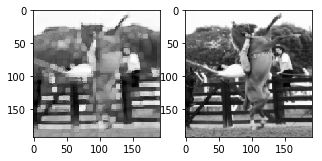

Testing Data : [0/400 (0%)]	Loss: 1286.607910
Time Spend : 2.312730312347412
PNSR Data number 0 : 19.9121431229708



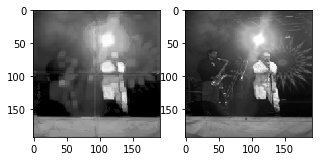

Testing Data : [1/400 (20%)]	Loss: 1286.607910
Time Spend : 1.7177376747131348
PNSR Data number 1 : 24.542020722461018



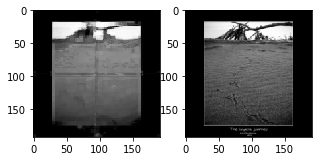

Testing Data : [2/400 (40%)]	Loss: 1286.607910
Time Spend : 1.7264533042907715
PNSR Data number 2 : 22.231758769257258



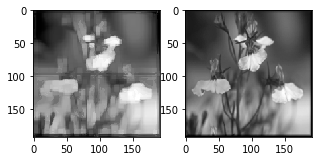

Testing Data : [3/400 (60%)]	Loss: 1286.607910
Time Spend : 1.7080256938934326
PNSR Data number 3 : 22.693346459155826



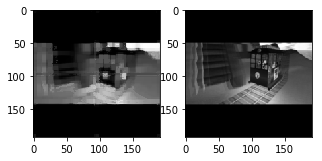

Testing Data : [4/400 (80%)]	Loss: 1286.607910
Time Spend : 1.6869244575500488
PNSR Data number 4 : 24.02065837365725



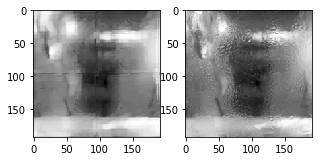

Testing Data : [5/400 (100%)]	Loss: 1286.607910
Time Spend : 1.7056193351745605
PNSR Data number 5 : 24.25007065180152



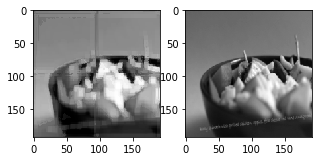

Testing Data : [6/400 (120%)]	Loss: 1286.607910
Time Spend : 1.8169314861297607
PNSR Data number 6 : 22.784029852233466



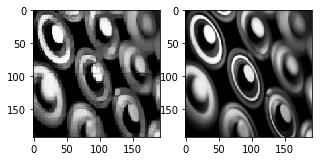

Testing Data : [7/400 (140%)]	Loss: 1286.607910
Time Spend : 1.71636962890625
PNSR Data number 7 : 20.130111036047836



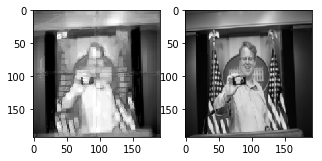

Testing Data : [8/400 (160%)]	Loss: 1286.607910
Time Spend : 1.7074229717254639
PNSR Data number 8 : 20.890775361050473



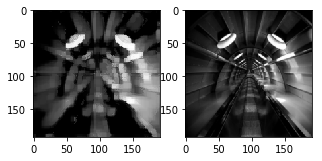

Testing Data : [9/400 (180%)]	Loss: 1286.607910
Time Spend : 1.70847749710083
PNSR Data number 9 : 21.552276945414558

Testing Result =====>
Loss : 231.9175537109375

Testing Success


In [0]:
import time
print("Begin Testing...")
epoch = 25
network.eval()
loss_temp = 0
counter = 0
block_size = 96
for batch_idx,(data,_) in enumerate(test_loader):
  start_ins = time.time()
  data = Variable(data)

  result = data.clone()
  # print(result.shape)
  for i in range(0,192,block_size):
    for j in range(0,192,block_size):
      sep = result[0][0][i:i+block_size,j:j+block_size]
      sep = sep.unsqueeze(0)
      sep = sep.unsqueeze(0)
      # print(sep.shape)
      recon_sep,_,_,_ = network(sep.cuda())
      # print(recon_sep.shape)
      result[0][0][i:i+block_size,j:j+block_size] = recon_sep
  
  temp_fig = plt.figure(batch_idx,figsize=(5,15))

  temp_fig.add_subplot(1,2,1)
  plt.imshow(result[0][0].detach().cpu().numpy(),cmap=plt.get_cmap('gray'))

  temp_fig.add_subplot(1,2,2)
  plt.imshow(data[0][0].numpy(),cmap=plt.get_cmap('gray'))

  loss_value = loss(data.cuda(),result.cuda())
  loss_temp += loss_value.item()/len(data)
  end_ins = time.time()
  
  plt.show()
  
  print('Testing Data : [{}/{} ({:.0f}%)]\tLoss: {:.6f}\nTime Spend : {}'.format(
                batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss_val.item() / len(data),
                end_ins - start_ins
                ))
  print('PNSR Data number {} : {}\n'.format(counter,psnr(data[0][0].numpy(),result[0][0].detach().cpu().numpy())))
  counter = counter+1
                 
print("Testing Result =====>\nLoss : {}\n".format((loss_temp/len(test_loader))))
print("Testing Success")

Data - 0 : 27.075806191893697

Data - 1 : 25.807849207926544

Data - 2 : 30.151066390338713

Data - 3 : 33.04186920326642

Data - 4 : 30.743662680010303

Data - 5 : 26.339737316517336

Data - 6 : 31.68587621953471

Data - 7 : 25.657802777271428

Data - 8 : 32.151732319250364

Data - 9 : 27.356966852441253



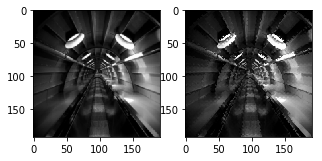

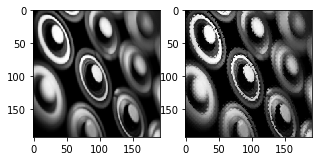

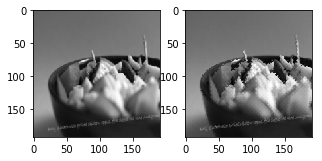

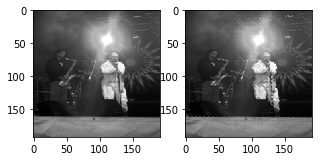

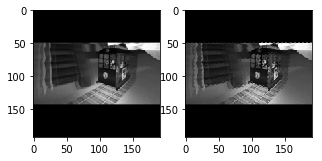

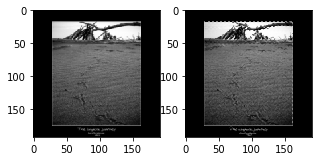

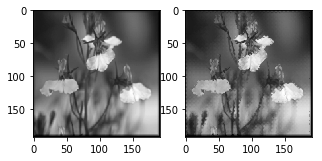

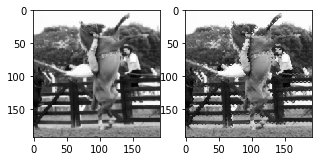

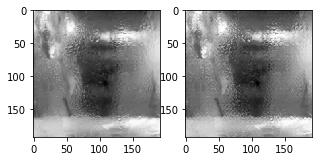

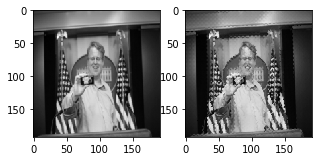

In [0]:
odbtc = ODBTC(2)
for batch_idx,(data,_) in enumerate(test_loader):
  data_numpy = data.clone().numpy()
  data_numpy = data_numpy[0]

  temp_od = odbtc(data_numpy)

  temp_fig = plt.figure(batch_idx,figsize=(5,15))

  temp_fig.add_subplot(1,2,1)
  plt.imshow(data[0][0].numpy(),cmap=plt.get_cmap('gray'))

  temp_fig.add_subplot(1,2,2)
  plt.imshow(temp_od[0],cmap=plt.get_cmap('gray'))

  print("Data - {} : {}\n".format(batch_idx,psnr(data[0][0].numpy(),temp_od[0])))
